# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This dataset represents 17 campaigns. 

From Moro and Laureano "The dataset collected is related to 17 campaignsthat occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered.  For each contact, a large number of attributes was stored and if there was sucess (the target variable). For the whole database considered, there were 6499 successes (8% success rate)"


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

import warnings
from sklearn import set_config
set_config(display="diagram")
warnings.filterwarnings('ignore')

# Functions for classification scores and plotting

In [115]:
# Computes all the scores from GridSearchCV and puts them into a nice dataframe
#
def make_class_score( clf, X_train, y_train, X_test, y_test, clf_text ):
    try:
        pca_nc = clf.best_params_['pca__n_components']
    except:
        pca_nc = np.nan
        
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    y_test_pred = clf.predict( X_test )
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score( y_test, y_pred_proba )
    tn, fp, fn, tp = confusion_matrix( y_test, y_test_pred ).ravel()
    spec = tn/(tn+fp)
    acc  = accuracy_score( y_test, y_test_pred )
    prec = precision_score( y_test, y_test_pred )
    rec  = recall_score( y_test, y_test_pred )
    f1   = f1_score( y_test, y_test_pred )
    fit_time = np.mean( clf.cv_results_['mean_fit_time'])
    print(f'acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} spec={spec:.3f} fit_time={fit_time:.3f}')

    auc = roc_auc_score( y_test, y_pred_proba )
    
    score_dict = {'CLF' : [clf_text], 
                  'PCA_ncomp':[pca_nc], 
                  'train_score':[round(train_score,3)], 
                  'accuracy':[round(acc,3)], 
                  'precision':[round(prec,3)], 
                  'recall':[round(rec,3)], 
                  'f1':[round(f1,3)], 
                  'specificity':[round(spec,3)],
                  'auc':[round(auc,3)],
                  'fit_time':[round(fit_time,3)] }
    df = pd.DataFrame(data=score_dict)
    return df

In [127]:
# This is same as above except for non GridSearchCV 
#  directly from classifier, no mean_fit_time from cv_results_ and pca n_components 
#
def make_class_score2( clf, X_train, y_train, X_test, y_test, clf_text ):
    pca_nc = np.nan   
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    y_test_pred = clf.predict( X_test )
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score( y_test, y_pred_proba )
    tn, fp, fn, tp = confusion_matrix( y_test, y_test_pred ).ravel()
    spec = tn/(tn+fp)
    acc  = accuracy_score( y_test, y_test_pred )
    prec = precision_score( y_test, y_test_pred )
    rec  = recall_score( y_test, y_test_pred )
    f1   = f1_score( y_test, y_test_pred )
    fit_time = np.nan
    print(f'acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} spec={spec:.3f} fit_time={fit_time:.3f}')
    
    score_dict = {'CLF' : [clf_text], 
                  'PCA_ncomp':[pca_nc], 
                  'train_score':[round(train_score,3)], 
                  'accuracy':[round(acc,3)], 
                  'precision':[round(prec,3)], 
                  'recall':[round(rec,3)], 
                  'f1':[round(f1,3)], 
                  'specificity':[round(spec,3)],
                  'auc':[round(auc,3)],
                  'fit_time':[round(fit_time,3)] }
    df = pd.DataFrame(data=score_dict)
    return df

In [128]:
## makes plots in 2x2 subplots for
##   confustion-matrix 
##   ROC curve
##   Precision-Recall curve
##
def make_plots( clf, X_test, y_test, clf_text ):
    """ make 2x2 plot with confustion-matrix, ROC curve, and Precision-Recall curve
        returns vectors fpr, tpr, precision, recall
        returns scalar auc
    :param clf: classifier 
    :param X_test: test split features X-independent variables
    :param y_test: test split target labels y-dependent variables
    :param clf_text: string name of classifier for labels 
    """  
    y_test_pred = clf.predict(X_test) 
    # y_pred_proba = clf.predict_proba(X_test)[::,1]
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    
### plot the Confusion-Matrix curve in upper-left
###
    fig, axs = plt.subplots(2,2, figsize=(8,8))
    fig.tight_layout(pad=5)
    clf_confusion_matrix = confusion_matrix( y_test, y_test_pred, normalize='true')
    sns.heatmap( clf_confusion_matrix, annot=True, ax=axs[0,0] )
    axs[0,0].set_xlabel('Predicted')
    axs[0,0].set_ylabel('Truth')
    axs[0,0].set_title('Confusion Matrix')

### plot the ROC curve in upper-right
###
    clf_fpr, clf_tpr, roc_thresholds = roc_curve( y_test,  y_pred_proba )
    clf_auc = roc_auc_score( y_test, y_pred_proba )
    legend_label_text = f'{clf_text} AUC={str(round(clf_auc,3))}'
    axs[0,1].plot( clf_fpr, clf_tpr, label=legend_label_text )
    axs[0,1].set_ylabel('True Positive Rate')
    axs[0,1].set_xlabel('False Positive Rate')
    axs[0,1].set_title('ROC')
    axs[0,1].legend()

### plot the Precision-Recall Curve in the lower-right
###
    precision = precision_score( y_test, y_test_pred )
    recall    = recall_score( y_test, y_test_pred )
    f1        = f1_score( y_test, y_test_pred )
    clf_precision, clf_recall, prc_thresholds = precision_recall_curve( y_test, y_pred_proba )
    axs[1,1].plot( clf_recall, clf_precision, label=clf_text )
    axs[1,1].set_ylabel('Precision')
    axs[1,1].set_xlabel('Recall')
    axs[1,1].set_title('Precision-Recall Curve')
    axs[1,1].plot( recall, precision, 'o' )
    txtlabel = f'f1={f1:.3f}'
    axs[1,1].text( recall, precision, txtlabel)
    axs[1,1].legend()

### plot lower left is empty
###
    axs[1, 0].axis('off')
    plt.show()
    
    return clf_fpr, clf_tpr, clf_auc, clf_precision, clf_recall

# load the dataframe from csv file

In [134]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [135]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**Business Objectives:**

Direct marketing campaigns are an inexpensive means to increase sales; however, the performance of direct phone marketing is largely unknown.

In addition to performance, more information is need for improvement in efficiency of direct phone marketing. The goal is to examine the peformance of multiple classifier methods and find the one that returns the best metrics.

In this situation, there is a low cost or penalty for type-I errors i.e., false alarms. In this case we're targeting customers with phone calls who are likely to already purchase products.  This is inefficient and maximizing precision will reduce costs and being a nuisance to buying customers.  Type-II errors or missed detections is more detremental due to missing sales oppurtunities that would help. Here we wish to maximize recall score. Since there is a large class imbalance, accuracy score is not the best metric given that most of the feature space is of the class 0 or 'no sale'. We therefore optimize for maximum f1-score (combination of recall and precision) but utimately also want to pick methods that optimize recall. 

Besides comparing the performance of the classifiers, we also wish to analize the imporatnce of the features and provide some interpretation so to improve the efficiency for future direct markinging methods.    

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [140]:
### asign a new column named target with numerical value 
### for categorical column y
###
df['target'] = 0
df.loc[df['y']=='no', 'target'] = 0
df.loc[df['y']=='yes', 'target'] = 1
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,target
27130,55,admin.,married,high.school,no,no,no,cellular,nov,fri,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no,0
17446,42,admin.,married,high.school,no,yes,yes,telephone,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0
33997,53,admin.,married,basic.9y,no,yes,yes,cellular,may,wed,...,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,yes,1
39350,34,blue-collar,single,unknown,no,no,no,cellular,mar,fri,...,999,0,nonexistent,-1.8,93.369,-34.8,0.636,5008.7,no,0
9091,47,entrepreneur,married,unknown,unknown,no,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no,0


In [142]:
df.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


In [130]:
### create the list of features (numerical and categorical)
###   and target with numerical labels
###
# features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
#
features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
            'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome' ]
X_orig = df[features]
y = df[['target']]
type(X_orig)

pandas.core.frame.DataFrame

In [132]:
### create the list of features for the encoder, use columnTransformer to make a new features dataframe 
###
enc_features = ['job', 'marital', 'education', 'default', 'housing', 
                'loan', 'contact', 'month', 'poutcome' ]

columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), enc_features)], remainder='passthrough')
XX = columnTransformer.fit_transform(X_orig)

X = pd.DataFrame(XX.todense(), columns=columnTransformer.get_feature_names_out())
print(type(X), X.shape)
X.head()

<class 'pandas.core.frame.DataFrame'> (41188, 53)


,encoder__job_admin.,encoder__job_blue-collar,encoder__job_entrepreneur,encoder__job_housemaid,encoder__job_management,encoder__job_retired,encoder__job_self-employed,encoder__job_services,encoder__job_student,encoder__job_technician,...,encoder__month_oct,encoder__month_sep,encoder__poutcome_failure,encoder__poutcome_nonexistent,encoder__poutcome_success,remainder__age,remainder__duration,remainder__campaign,remainder__pdays,remainder__previous
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,56.0,261.0,1.0,999.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,57.0,149.0,1.0,999.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,37.0,226.0,1.0,999.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,40.0,151.0,1.0,999.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,56.0,307.0,1.0,999.0,0.0


In [144]:
# X.corr()

# Principal Component Analysis 

Given that there are 53 features we use PCA do see if we can reduce the number of dimensions. The features are scaled by the mean and standard deviations.  

In [52]:
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(Xscaled)
#
print("n_components= " + str(pca.n_components_) )
# print("explained_variance_ratio_= " + str( pca.explained_variance_ratio_ )  )
# print("")
# print("singular_values_ = " + str( pca.singular_values_) )

n_components= 53


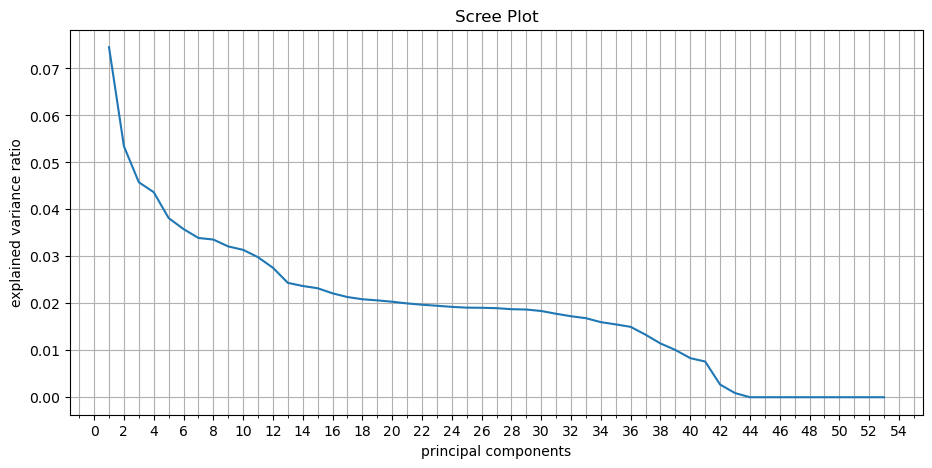

In [41]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
# print( pca.explained_variance_ratio_.shape )
x = np.arange(1,54,1)

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot( x, pca.explained_variance_ratio_ )
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel("principal components")
ax.set_ylabel("explained variance ratio")
ax.set_title("Scree Plot")
ax.grid(visible=True, which='both')
plt.show()

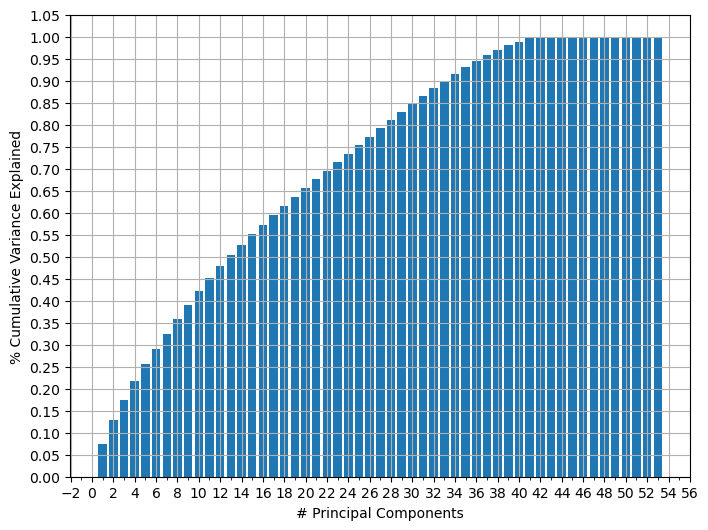

In [51]:
cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,54), cum_exp_var)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');
ax.grid()
plt.show()

Based on the cummlative explain variance for all 53 principal components, we decided to grid search over 24, 32, 36 number of principal components to capture at least 75% to 95% of all the variance in the features. The significance, here is that we reduce the run time for training the classification models by using at least 17 fewer features.  As a test using some of the faster classifier models (not SVM), we also consider all original 53 untransformed features.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.  We hold out 30% of the dataset for later testing/scoring and train with 70%.  

In [16]:
X_train , X_test ,y_train, y_test = train_test_split(X, y, test_size =0.3, random_state =42)
print(f'training X dim {X_train.shape}' )
print(f'testing  X dim {X_test.shape}' )
print(f'training Y dim {y_train.shape}' )
print(f'testing  Y dim {y_test.shape}' )

training X dim (28831, 53)
testing  X dim (12357, 53)
training Y dim (28831, 1)
testing  Y dim (12357, 1)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

# Baseline Classifer

In [22]:
dummy_clf = DummyClassifier().fit(X_train, y_train)
#
train_score = dummy_clf.score(X_train, y_train)
test_score = dummy_clf.score(X_test, y_test)
print(f'train_score={train_score:.3f} test_score={test_score:.3f}')
#
y_test_pred = dummy_clf.predict(X_test) 
accuracy  = accuracy_score( y_test, y_test_pred )
precision = precision_score( y_test, y_test_pred )
recall    = recall_score( y_test, y_test_pred )
f1 = f1_score( y_test, y_test_pred )
print(f'acc={accuracy:.3f} pre={precision:.3f} rec={recall:.3f} f1={f1:.3f}')

train_score=0.887 test_score=0.888
acc=0.888 pre=0.000 rec=0.000 f1=0.000


In [111]:
tmp = make_class_score2( dummy_clf, X_train, y_train, X_test, y_test, "Baseline" )
tmp

acc=0.888 prec=0.000 rec=0.000 f1=0.000 spec=1.000 fit_time=nan


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,Baseline,NaN,0.887,0.888,0.0,0.0,0.0,1.0,0.5,NaN


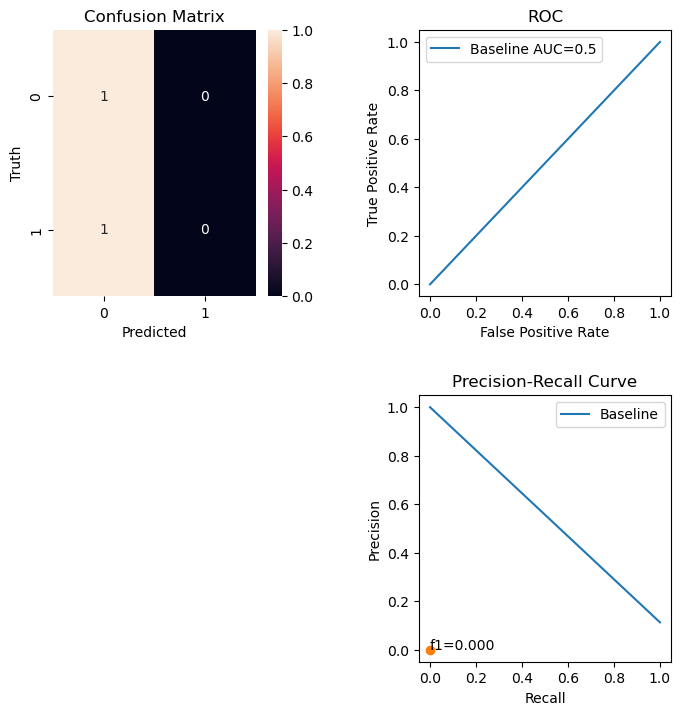

In [27]:
dum_fpr, dum_tpr, dum_auc, dum_precision, dum_recall = make_plots(dummy_clf, X_test, y_test, "Baseline")

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [53]:
lgr_pipe = Pipeline([
    ( "pca", PCA()),
    ( "scaler", StandardScaler()),
    ( "lgr", LogisticRegression())
])

# "lgr__solver" : ["lbfgs", "liblinear", "newton-cg", "sag", "saga"]
# 53 features
params = {
    "pca__n_components" : [ 24, 32, 36 ],
    "lgr__C" : [ 0.001, 0.002, 0.003, 0.005, 0.01, 0.03, 0.1, 1, 10, 100 ],
    "lgr__solver" : ["lbfgs"]
}

# scoring : accuracy, *roc_auc, *f1, recall, precision

lgr_grid = GridSearchCV( lgr_pipe, param_grid=params, cv=5, scoring='f1', verbose=0).fit(X_train,y_train)
print(lgr_grid.best_estimator_)
print(f'best param={lgr_grid.best_params_}  best score={lgr_grid.best_score_:.3f}')

Pipeline(steps=[('pca', PCA(n_components=36)), ('scaler', StandardScaler()),
                ('lgr', LogisticRegression(C=1))])
best param={'lgr__C': 1, 'lgr__solver': 'lbfgs', 'pca__n_components': 36}  best score=0.452


In [116]:
#reset at start
# df_scores.drop(df_scores.index,inplace=True) 
df_scores = make_class_score( lgr_grid, X_train, y_train, X_test, y_test, "LogisticRegression" )
df_scores

acc=0.907 prec=0.662 rec=0.348 f1=0.456 spec=0.977 fit_time=0.175


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,LogisticRegression,36,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175


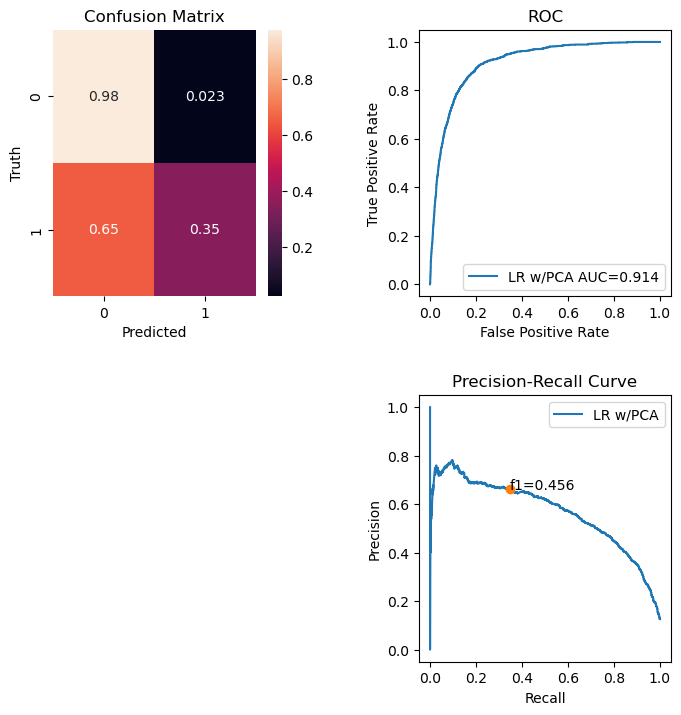

In [55]:
lgr_fpr, lgr_tpr, lgr_auc, lgr_precision, lgr_recall = make_plots(lgr_grid, X_test, y_test, "LR w/PCA")

# Logistic Regression Classifier without PCA

In [57]:
lgr_pipe2 = Pipeline([
    ( "scaler", StandardScaler()),
    ( "lgr", LogisticRegression())
])
params = {
    "lgr__C" : [ 0.001, 0.002, 0.003, 0.005, 0.01, 0.03, 0.1, 1, 10, 100 ],
    "lgr__solver" : ["lbfgs"]
}
lgr_grid2 = GridSearchCV( lgr_pipe2, param_grid=params, cv=5, scoring='f1', verbose=0).fit(X_train,y_train)
print(lgr_grid2.best_estimator_)
print(f'best param={lgr_grid2.best_params_}  best score={lgr_grid2.best_score_:.3f}')

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgr', LogisticRegression(C=0.1))])
best param={'lgr__C': 0.1, 'lgr__solver': 'lbfgs'}  best score=0.457


In [117]:
tmp = make_class_score( lgr_grid2, X_train, y_train, X_test, y_test, "LogisticRegression2" )
df_scores = df_scores.append(tmp, ignore_index = True)
df_scores

acc=0.908 prec=0.673 rec=0.358 f1=0.467 spec=0.978 fit_time=0.058


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058


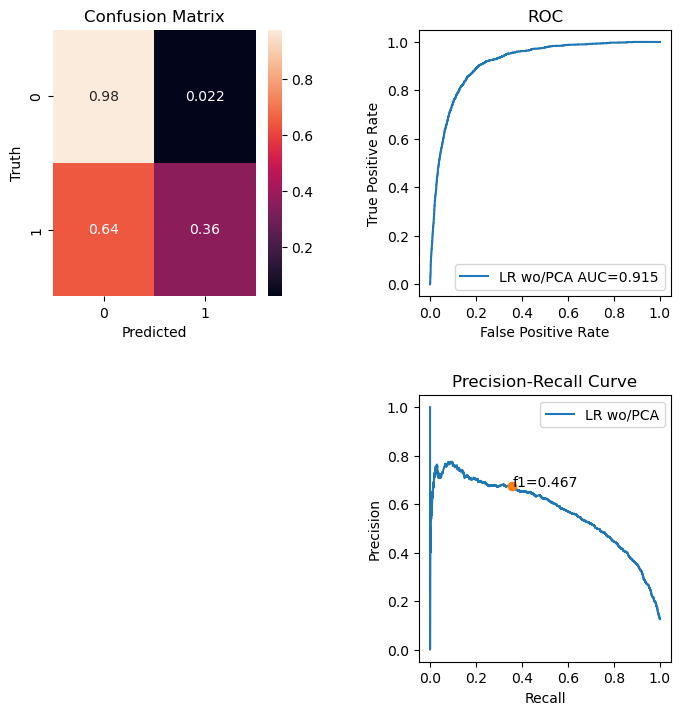

In [59]:
lgr2_fpr, lgr2_tpr, lgr2_auc, lgr2_precision, lgr2_recall = make_plots(lgr_grid2, X_test, y_test, "LR wo/PCA")

# KNeighborsClassifier with PCA

In [60]:
knn_pipe = Pipeline([
    ( "scaler", StandardScaler()),
    ( "pca", PCA()),
    ( "knn", KNeighborsClassifier())
])
# 53features - use PCA reduce dimensionality
params = {
    "pca__n_components" : [ 24, 32, 36 ],
    "knn__n_neighbors" : [ 8, 9, 10, 11, 12, 13, 14, 15 ] 
}

knn_grid = GridSearchCV( knn_pipe, param_grid=params, cv=5, scoring='f1', verbose=0).fit(X_train,y_train)
print(knn_grid.best_estimator_)
print(f'best param={knn_grid.best_params_}  best score={knn_grid.best_score_:.3f}')

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=32)),
                ('knn', KNeighborsClassifier(n_neighbors=9))])
best param={'knn__n_neighbors': 9, 'pca__n_components': 32}  best score=0.357


In [118]:
tmp = make_class_score( knn_grid, X_train, y_train, X_test, y_test, "KNeighbors" )
df_scores = df_scores.append(tmp, ignore_index = True)
df_scores

acc=0.899 prec=0.615 rec=0.273 f1=0.378 spec=0.978 fit_time=0.141


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058
2,KNeighbors,32.0,0.453,0.899,0.615,0.273,0.378,0.978,0.831,0.141


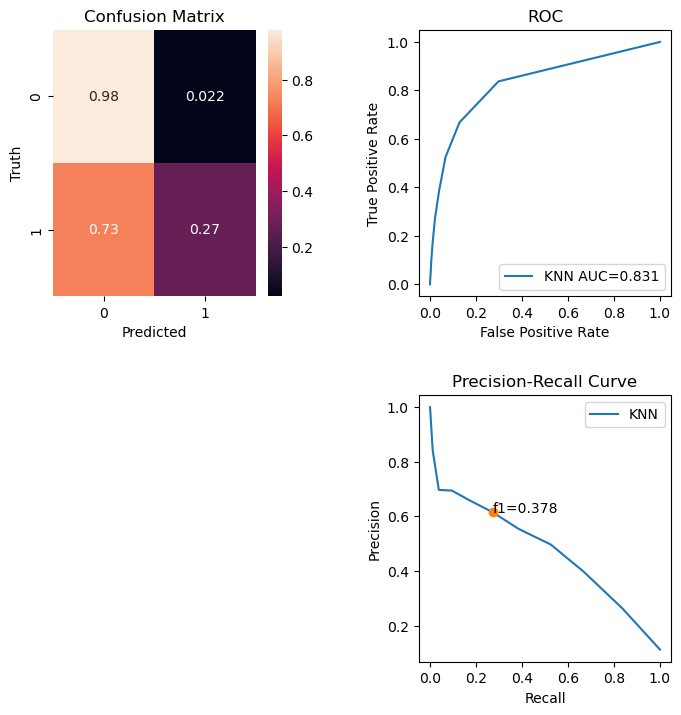

In [62]:
knn_fpr, knn_tpr, knn_auc, knn_precision, knn_recall = make_plots(knn_grid, X_test, y_test, "KNN")

# KNeighborsClassifier without PCA

In [74]:
knn_pipe2 = Pipeline([
    ( "scaler", StandardScaler()),
    ( "knn", KNeighborsClassifier())
])

# use all 53 features 
params = {
    "knn__n_neighbors" : [ 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ] 
}

knn_grid2 = GridSearchCV( knn_pipe2, param_grid=params, cv=5, scoring='f1', verbose=0).fit(X_train,y_train)
print(knn_grid2.best_estimator_)
print(f'best param={knn_grid2.best_params_}  best score={knn_grid2.best_score_:.3f}')

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])
best param={'knn__n_neighbors': 9}  best score=0.345


In [119]:
tmp = make_class_score( knn_grid2, X_train, y_train, X_test, y_test, "KNeighbors2" )
df_scores = df_scores.append(tmp, ignore_index = True)
df_scores

acc=0.898 prec=0.604 rec=0.265 f1=0.368 spec=0.978 fit_time=0.020


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058
2,KNeighbors,32.0,0.453,0.899,0.615,0.273,0.378,0.978,0.831,0.141
3,KNeighbors2,NaN,0.442,0.898,0.604,0.265,0.368,0.978,0.821,0.020


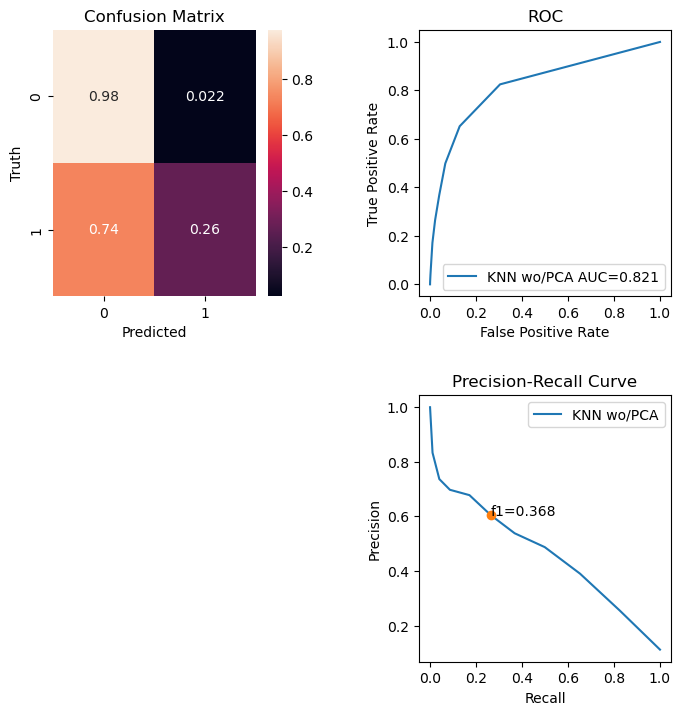

In [76]:
knn2_fpr, knn2_tpr, knn2_auc, knn2_precision, knn2_recall = make_plots(knn_grid2, X_test, y_test, "KNN wo/PCA")

# SVM classifier

In [84]:
svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ("pca", PCA()),
    ('svc', SVC(probability=True, tol=1.0e-3, max_iter=1000000, cache_size=1000000))
])

# "pca__n_components" : [ 24, 32, 36 ],
params = {
    "pca__n_components" : [ 36 ],
    "svc__kernel" : [ 'rbf' ],
    "svc__C" : [ 0.1, 1, 10, 100 ]
}

svc_grid = GridSearchCV(svc_pipe, param_grid=params, cv=5, scoring='f1', verbose=3).fit(X_train, y_train)

print(svc_grid.best_estimator_)
print(f'best param={svc_grid.best_params_}  best score={svc_grid.best_score_:.3f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END pca__n_components=36, svc__C=0.1, svc__kernel=rbf;, score=0.273 total time=  57.9s
[CV 2/5] END pca__n_components=36, svc__C=0.1, svc__kernel=rbf;, score=0.255 total time=  58.6s
[CV 3/5] END pca__n_components=36, svc__C=0.1, svc__kernel=rbf;, score=0.264 total time=  59.5s
[CV 4/5] END pca__n_components=36, svc__C=0.1, svc__kernel=rbf;, score=0.257 total time=  59.0s
[CV 5/5] END pca__n_components=36, svc__C=0.1, svc__kernel=rbf;, score=0.293 total time=  56.1s
[CV 1/5] END pca__n_components=36, svc__C=1, svc__kernel=rbf;, score=0.397 total time=  55.9s
[CV 2/5] END pca__n_components=36, svc__C=1, svc__kernel=rbf;, score=0.384 total time=  58.1s
[CV 3/5] END pca__n_components=36, svc__C=1, svc__kernel=rbf;, score=0.407 total time=  56.9s
[CV 4/5] END pca__n_components=36, svc__C=1, svc__kernel=rbf;, score=0.379 total time=  57.5s
[CV 5/5] END pca__n_components=36, svc__C=1, svc__kernel=rbf;, score=0.412 total tim

In [120]:
tmp = make_class_score( svc_grid, X_train, y_train, X_test, y_test, "SVC" )
df_scores = df_scores.append(tmp, ignore_index = True)
df_scores

acc=0.896 prec=0.544 rec=0.443 f1=0.489 spec=0.953 fit_time=60.412


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058
2,KNeighbors,32.0,0.453,0.899,0.615,0.273,0.378,0.978,0.831,0.141
3,KNeighbors2,NaN,0.442,0.898,0.604,0.265,0.368,0.978,0.821,0.020
4,SVC,36.0,0.825,0.896,0.544,0.443,0.489,0.953,0.866,60.412


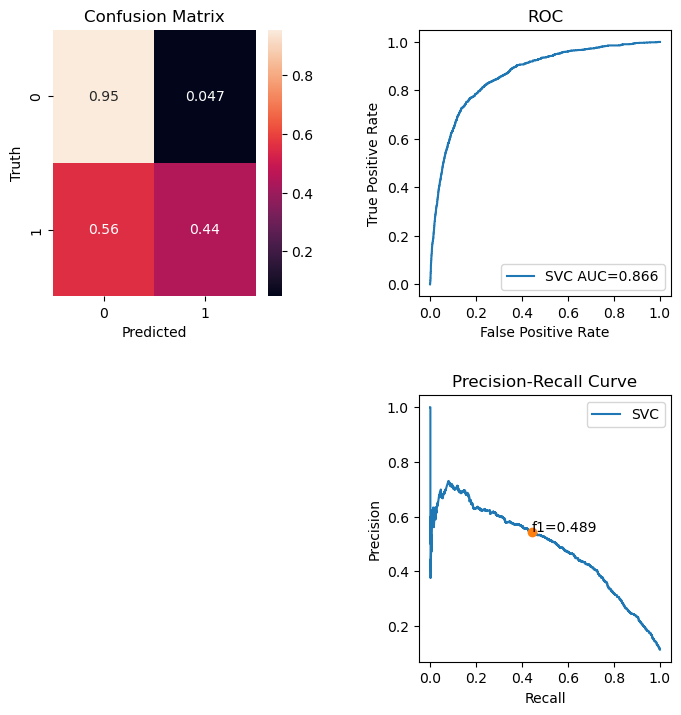

In [86]:
svc_fpr, svc_tpr, svc_auc, svc_precision, svc_recall = make_plots( svc_grid, X_test, y_test, "SVC")

# DecisionTreeClassifier with PCA

In [87]:
tree_pipe = Pipeline([
    ('scale', StandardScaler()),
    ("pca", PCA()),
    ('tree', DecisionTreeClassifier(random_state=42))
])

params = { 
    "pca__n_components" : [ 24, 32, 36 ],
    'tree__criterion' : ['gini', 'entropy'], 
    'tree__max_depth' : [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ]
}

tree_grid = GridSearchCV(tree_pipe, param_grid=params, cv=5, scoring='f1', verbose=0).fit(X_train, y_train)

print(tree_grid.best_estimator_)
print(f'best param={tree_grid.best_params_}  best score={tree_grid.best_score_:.3f}')

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=36)),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=12,
                                        random_state=42))])
best param={'pca__n_components': 36, 'tree__criterion': 'entropy', 'tree__max_depth': 12}  best score=0.459


In [121]:
tmp = make_class_score( tree_grid, X_train, y_train, X_test, y_test, "DecisionTree" )
df_scores = df_scores.append(tmp, ignore_index = True)
df_scores

acc=0.889 prec=0.509 rec=0.434 f1=0.469 spec=0.947 fit_time=0.878


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058
2,KNeighbors,32.0,0.453,0.899,0.615,0.273,0.378,0.978,0.831,0.141
3,KNeighbors2,NaN,0.442,0.898,0.604,0.265,0.368,0.978,0.821,0.020
4,SVC,36.0,0.825,0.896,0.544,0.443,0.489,0.953,0.866,60.412
5,DecisionTree,36.0,0.752,0.889,0.509,0.434,0.469,0.947,0.766,0.878


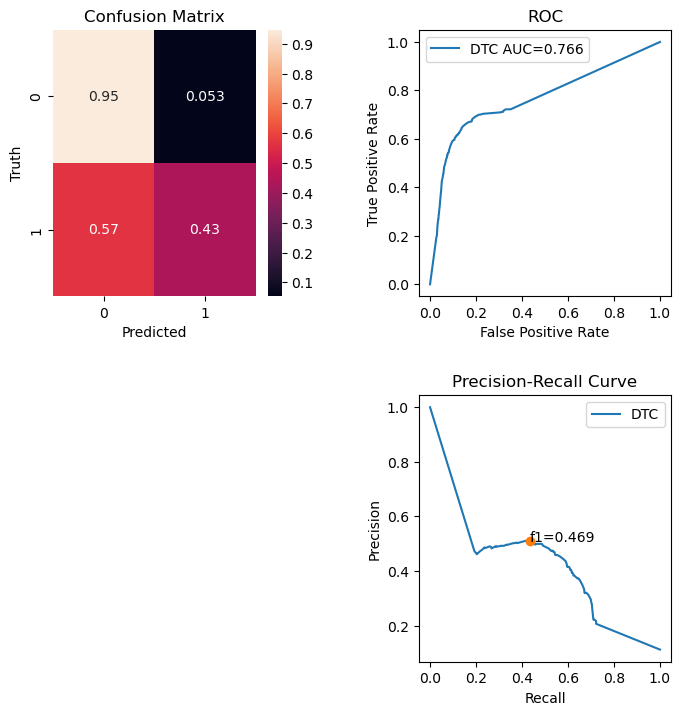

In [89]:
tree_fpr, tree_tpr, tree_auc, tree_precision, tree_recall = make_plots( tree_grid, X_test, y_test, "DTC")

# DecisionTreeClassifier without PCA

In [90]:
tree_pipe2 = Pipeline([
    ('scale', StandardScaler()),
    ('tree', DecisionTreeClassifier(random_state=42))
])

params2 = { 
    'tree__criterion' : ['gini', 'entropy'], 
    'tree__max_depth' : [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ]
}

tree_grid2 = GridSearchCV(tree_pipe2, param_grid=params2, cv=5, scoring='f1', verbose=0).fit(X_train, y_train)

print(tree_grid2.best_estimator_)
print(f'best param={tree_grid2.best_params_}  best score={tree_grid2.best_score_:.3f}')

Pipeline(steps=[('scale', StandardScaler()),
                ('tree', DecisionTreeClassifier(max_depth=9, random_state=42))])
best param={'tree__criterion': 'gini', 'tree__max_depth': 9}  best score=0.508


In [122]:
tmp = make_class_score( tree_grid2, X_train, y_train, X_test, y_test, "DecisionTree2" )
df_scores_FINAL = df_scores.append(tmp, ignore_index = True)
df_scores_FINAL

acc=0.907 prec=0.641 rec=0.390 f1=0.485 spec=0.972 fit_time=0.088


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058
2,KNeighbors,32.0,0.453,0.899,0.615,0.273,0.378,0.978,0.831,0.141
3,KNeighbors2,NaN,0.442,0.898,0.604,0.265,0.368,0.978,0.821,0.020
4,SVC,36.0,0.825,0.896,0.544,0.443,0.489,0.953,0.866,60.412
5,DecisionTree,36.0,0.752,0.889,0.509,0.434,0.469,0.947,0.766,0.878
6,DecisionTree2,NaN,0.590,0.907,0.641,0.390,0.485,0.972,0.865,0.088


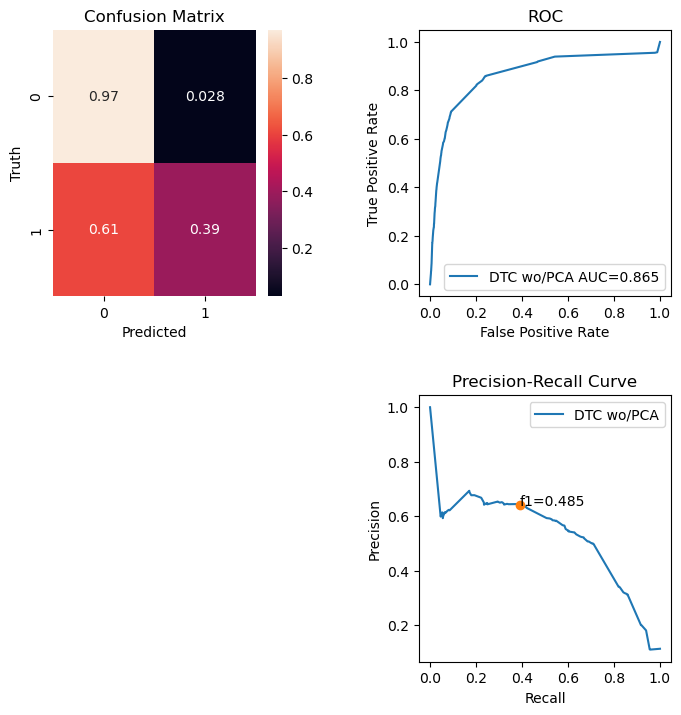

In [92]:
tree2_fpr, tree2_tpr, tree2_auc, tree2_precision, tree2_recall = make_plots( tree_grid2, X_test, y_test, "DTC wo/PCA")

### Problem 9: Score the Model

What is the accuracy of your model?

In [63]:
# Type I error - false alarm - false positive error - maximize precision
# Type II error - missed detection - false negative error - maximize recall

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [123]:
df_scores_FINAL.sort_values(['f1'],ascending=False)

,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
4,SVC,36.0,0.825,0.896,0.544,0.443,0.489,0.953,0.866,60.412
6,DecisionTree2,NaN,0.590,0.907,0.641,0.390,0.485,0.972,0.865,0.088
5,DecisionTree,36.0,0.752,0.889,0.509,0.434,0.469,0.947,0.766,0.878
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
2,KNeighbors,32.0,0.453,0.899,0.615,0.273,0.378,0.978,0.831,0.141
3,KNeighbors2,NaN,0.442,0.898,0.604,0.265,0.368,0.978,0.821,0.020


In [124]:
df_scores_FINAL.sort_values(['recall'],ascending=False)

,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,specificity,auc,fit_time
4,SVC,36.0,0.825,0.896,0.544,0.443,0.489,0.953,0.866,60.412
5,DecisionTree,36.0,0.752,0.889,0.509,0.434,0.469,0.947,0.766,0.878
6,DecisionTree2,NaN,0.590,0.907,0.641,0.390,0.485,0.972,0.865,0.088
1,LogisticRegression2,NaN,0.462,0.908,0.673,0.358,0.467,0.978,0.915,0.058
0,LogisticRegression,36.0,0.459,0.907,0.662,0.348,0.456,0.977,0.914,0.175
2,KNeighbors,32.0,0.453,0.899,0.615,0.273,0.378,0.978,0.831,0.141
3,KNeighbors2,NaN,0.442,0.898,0.604,0.265,0.368,0.978,0.821,0.020


SVC and DecisionTreeClassifier methods had the best f1-scores and recall-scores.

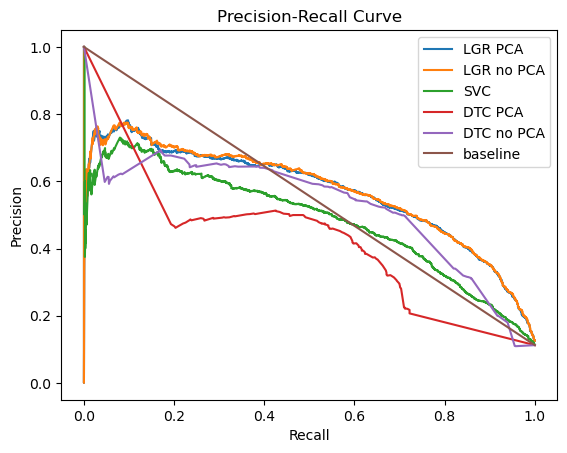

In [125]:
plt.plot( lgr_recall,   lgr_precision,   label="LGR PCA")
plt.plot( lgr2_recall,  lgr2_precision,  label="LGR no PCA")
plt.plot( svc_recall,   svc_precision,   label="SVC")
# plt.plot( knn_recall,   knn_precision,   label="KNN")
# plt.plot( knn2_recall,  knn2_precision,  label="KNN no PCA")
plt.plot( tree_recall,  tree_precision,  label="DTC PCA")
plt.plot( tree2_recall, tree2_precision, label="DTC no PCA")
plt.plot( dum_recall,   dum_precision,   label="baseline")

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Above, we see that SVC and DecisionTreeClassifier methods work the best. Also LogisticRegression worked well and performed the best with highest AUC in the following ROC curves.   

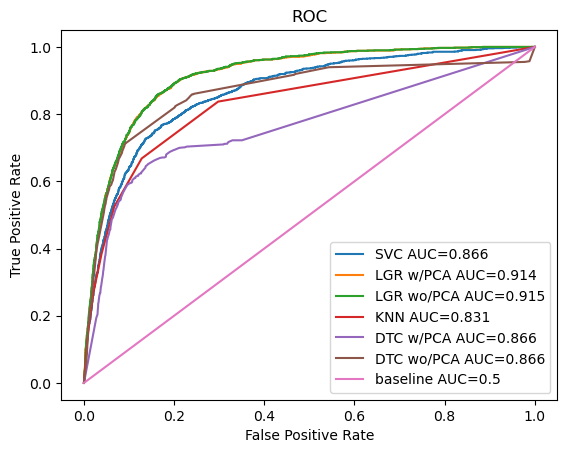

In [108]:
plt.plot( svc_fpr,   svc_tpr,   label="SVC AUC="+str(round(svc_auc,3)))
plt.plot( lgr_fpr,   lgr_tpr,   label="LGR w/PCA AUC="+str(round(lgr_auc,3)))
plt.plot( lgr2_fpr,  lgr2_tpr,  label="LGR wo/PCA AUC="+str(round(lgr2_auc,3)))
plt.plot( knn_fpr,   knn_tpr,   label="KNN AUC="+str(round(knn_auc,3)))
plt.plot( tree_fpr,  tree_tpr,  label="DTC w/PCA AUC="+str(round(svc_auc,3)))
plt.plot( tree2_fpr, tree2_tpr, label="DTC wo/PCA AUC="+str(round(svc_auc,3)))
plt.plot( dum_fpr,   dum_tpr,   label="baseline AUC="+str(round(dum_auc,3)))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [64]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

test_tree = DecisionTreeClassifier(criterion='gini', max_depth=9, random_state=42).fit(X_train_sc,y_train)
test_tree

DecisionTreeClassifier(max_depth=9, random_state=42)

In [65]:
print(test_tree.classes_)
print(test_tree.max_features_)
print(test_tree.feature_importances_)

[0 1]
53
[1.35610997e-03 0.00000000e+00 4.27792646e-04 3.24968231e-04
 1.50031951e-03 1.31797261e-03 2.14506431e-03 2.20736077e-03
 5.85549726e-03 2.48402518e-03 3.03786932e-03 0.00000000e+00
 2.78907846e-03 1.71923920e-03 2.92845074e-03 0.00000000e+00
 2.18574173e-03 3.32457765e-03 2.42521751e-03 5.99822577e-03
 0.00000000e+00 2.02850906e-03 3.48151105e-03 9.92165972e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.99702500e-04 4.77971001e-03 1.98643300e-03 5.24193652e-04
 8.45857939e-04 9.45478014e-03 2.15992886e-02 1.33836084e-02
 0.00000000e+00 1.02932572e-03 3.27919314e-03 2.48379690e-02
 3.45307267e-02 8.47291795e-03 3.98349841e-03 3.36849382e-02
 1.42218419e-02 8.42454084e-04 0.00000000e+00 1.06485929e-03
 5.31623908e-02 4.59215525e-01 1.56796995e-02 2.39775257e-01
 4.51613184e-03]


In [66]:
tmp = make_class_score2( test_tree, X_train_sc, y_train, X_test_sc, y_test, "TestTree" )
tmp

acc=0.900 prec=0.614 rec=0.293 f1=0.397 spec=0.977 fit_time=nan


,CLF,PCA_ncomp,train_score,accuracy,precision,recall,f1,fit_time
0,TestTree,NaN,0.925,0.9,0.614,0.293,0.397,NaN


In [72]:
df_featimp = pd.DataFrame( test_tree.feature_importances_, index=X.columns, columns=['Gini-Feature Importance'])
df_featimp['features'] = X.columns
df_featimp.reset_index(inplace=True)
df_featimp_sorted=df_featimp.sort_values('Gini-Feature Importance', ascending=False)

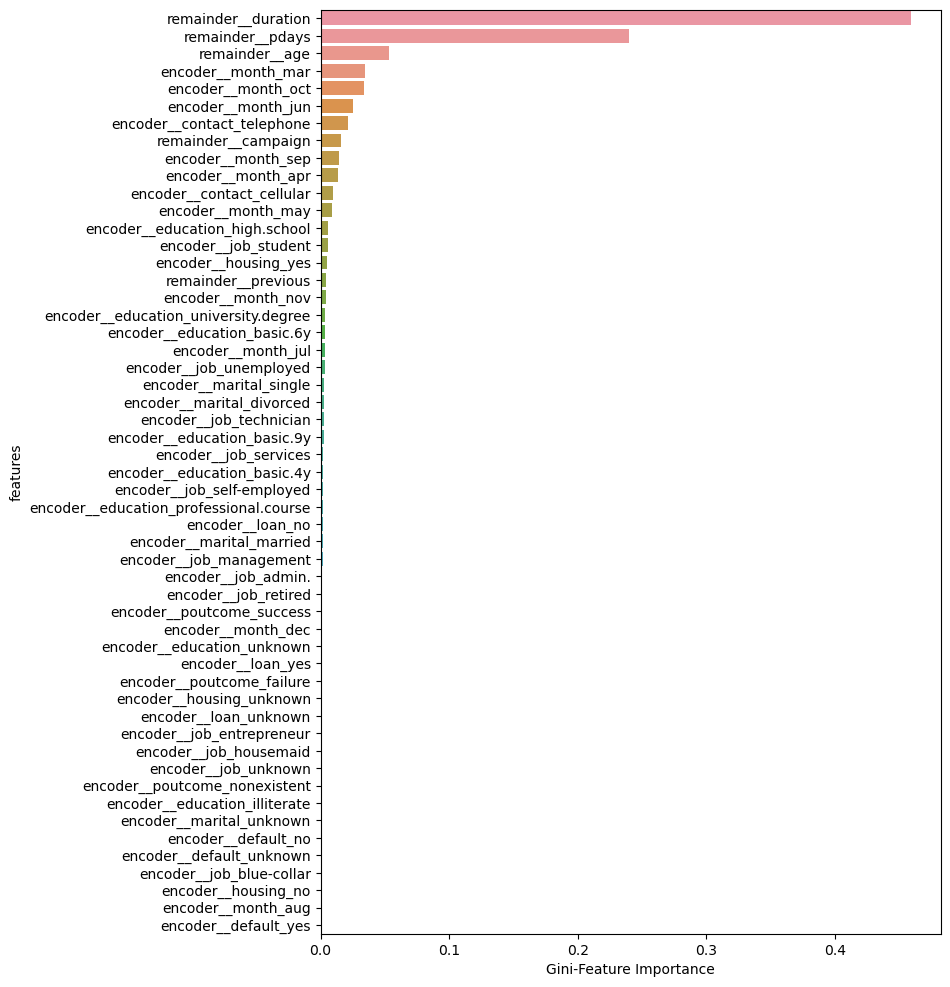

In [73]:
plt.figure(figsize=(8,12))
sns.barplot( data=df_featimp_sorted, x='Gini-Feature Importance', y='features' )
plt.show()

above the feature importance is the highest for the duration of the phone marketing calls, the number of days previous contact, and age.  The months also factor in with March, October and June being most important. 

**Findings:**

1. PCA reduced the number of features needed to train classifiers mainly reducing the number of non-important features by about 17 (53 to 36). The percent cumlative variance explaination was 95% with number of principal componets at 36. 


2. SVM and Decision Tree Classifier performed the best f1-score. SVM took about 50 times slower than Decision Tree Classifier. 


3. We used the GridsearchCV for the best hyperparameters. These were used with the Decision Tree Classifier to estimate the Gini-feature Importance for the 53 features.  We find that the feature importance is the highest for the duration of the phone marketing calls, the number of days previous contact, and age. The months also factor in with March, October and June being most important. This is similar finding with the Moro and Laureano paper. 

**Future work:**
1. The next step is to examine the thresholds which here are assumed to be probability of 0.5. 
2. We also did not use the social economic variables given that they would not be available for future predictions.  However, it would be interesting to included them to see if they give any improvement in the classifiers. 

##### Questions